# Functional

In [1]:
import os

import cv2
import numpy as np

import requests
from PIL import Image
import torch
from transformers import DepthProImageProcessorFast, DepthProForDepthEstimation

import open3d as o3d
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import ipywidgets as widgets
from IPython.display import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
image_processor = DepthProImageProcessorFast.from_pretrained("apple/DepthPro-hf")
model = DepthProForDepthEstimation.from_pretrained("apple/DepthPro-hf").to(device)

def make_depth(image):
    image = Image.fromarray(image)
    inputs = image_processor(images=image, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    post_processed_output = image_processor.post_process_depth_estimation(
        outputs, target_sizes=[(image.height, image.width)],
    )
    
    depth_numpy = post_processed_output[0]["predicted_depth"].cpu().numpy()

    return depth_numpy

def minpool2d_nearest_pad(i, kernel_size, stride=1, padding=0):
    if padding > 0:
        input_padded = np.pad(i, 
                              pad_width=((padding, padding), (padding, padding)),
                              mode='edge')
    else:
        input_padded = i

    H, W = input_padded.shape
    out_h = (H - kernel_size) // stride + 1
    out_w = (W - kernel_size) // stride + 1

    output = np.zeros((out_h, out_w))

    for i in range(out_h):
        for j in range(out_w):
            h_start = i * stride
            h_end = h_start + kernel_size
            w_start = j * stride
            w_end = w_start + kernel_size
            output[i, j] = np.min(input_padded[h_start:h_end, w_start:w_end])

    return output


DEFAULT_Z_SCALE = 100

def norm_0_to_zscale(point_arr, z_scale=DEFAULT_Z_SCALE):
    point_arr = point_arr.copy()
    point_arr[..., 2] = ((point_arr[..., 2] - np.min(point_arr[..., 2])) / (np.max(point_arr[..., 2]) - np.min(point_arr[..., 2]))) * z_scale
    return point_arr

In [3]:
def point_cloud_filter_and_show_o3d(points, colors, threshold_distance=1.5):

    # Init PCD
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors / 255)

    points = np.asarray(pcd.points)
    colors = np.asarray(pcd.colors)

    pcd_tree = o3d.geometry.KDTreeFlann(pcd)

    filtered_points = points
    filtered_colors = colors
    if threshold_distance is not None:
        indices_to_keep = []
        
        for i, point in enumerate(points):
            [k, idx, _] = pcd_tree.search_knn_vector_3d(point, 2)  # 2 because the closest neighbor is the point itself
            spatial_distance = np.linalg.norm(points[idx[1]] - point)  # Distance to the second closest point
            
            if spatial_distance < threshold_distance:
                indices_to_keep.append(i)
        
        filtered_points = points[indices_to_keep]
        filtered_colors = colors[indices_to_keep]
        
    filtered_pcd = o3d.geometry.PointCloud()
    filtered_pcd.points = o3d.utility.Vector3dVector(filtered_points)
    filtered_pcd.colors = o3d.utility.Vector3dVector(filtered_colors)
    
    o3d.visualization.draw_geometries([filtered_pcd])


def convert_point_cloud_to_mesh_and_show(point_array, color_array):

    points = point_array
    colors = color_array / 255
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))
    pcd.orient_normals_consistent_tangent_plane(16)
    
    mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8)
    
    bbox = pcd.get_axis_aligned_bounding_box()
    mesh = mesh.crop(bbox)
    
    mesh_vertices = np.asarray(mesh.vertices)
    pcd_points = np.asarray(pcd.points)
    pcd_colors = np.asarray(pcd.colors)
    
    kdtree = cKDTree(pcd_points)
    _, idx = kdtree.query(mesh_vertices, k=1)
    mesh_colors = pcd_colors[idx]
    
    mesh.vertex_colors = o3d.utility.Vector3dVector(mesh_colors)
    
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    colors = np.asarray(mesh.vertex_colors)
    
    mesh_colors = (pcd_colors[idx] * 255).astype(np.uint8)
    
    intensity = np.dot(mesh_colors,  [1, 1, 1])  # Standard luminosity formula
    fig = go.Figure(data=[
        go.Mesh3d(
            x=mesh_vertices[:, 0],
            y=mesh_vertices[:, 1],
            z=mesh_vertices[:, 2],
            i=np.asarray(mesh.triangles)[:, 0],
            j=np.asarray(mesh.triangles)[:, 1],
            k=np.asarray(mesh.triangles)[:, 2],
            intensity=intensity,  # Apply intensity to control color
            colorscale='gray',  # Use a colorscale, you can use 'Rainbow', 'Jet', etc.
            lighting=dict(ambient=1.0, diffuse=0.8),
            opacity=1.0,
        )
    ])
    
    fig.update_layout(scene=dict(aspectmode='data'))
    fig.show()

In [4]:
def ortho_from_pointcloud(points, height, width, res=1, colors=None):
    x, y, z = points[:,0], points[:,1], points[:,2]
    x_min, y_min = x.min(), y.min()
    
    # Convert to grid
    i = ((x - x_min) / res).astype(int)
    j = ((y - y_min) / res).astype(int)
    
    # width, height = i.max() + 1, j.max() + 1
    img = np.zeros((height, width), dtype=np.float32)
    if colors is not None:
        img = np.zeros((height, width, 3), dtype=np.uint8)
        
    
    depth = np.full((height, width), -np.inf)  # For z-buffer
    for idx in range(len(points)):
        jj, ii = i[idx], j[idx]
        try:
            if z[idx] > depth[jj, ii]:
                depth[jj, ii] = z[idx]
                
                if colors is not None:
                    img[jj, ii] = colors[idx]
                else:
                    img[jj, ii] = z[idx]
        except:
            continue
    
    return img

# Run

## Config

In [5]:
# Image path
IMAGE_PATH = './sample_image.png'
if not os.path.exists(IMAGE_PATH): raise ValueError(f'Image file not exists {str(IMAGE_PATH)}')


# Processing config

# Resize image for processing
DST_SIZE = (768, 768)

# Remove background by substracting min surface
MIN_POOL_KERNEL = 127
MIN_POOL_PADDING = 63
GAUSSIAN_BLUR_SIGMA = 63

# Filter out outlier points in PoinCloud visualization
THESHOLD_DISTANCE = 1.5

## Data loading and preprocessing

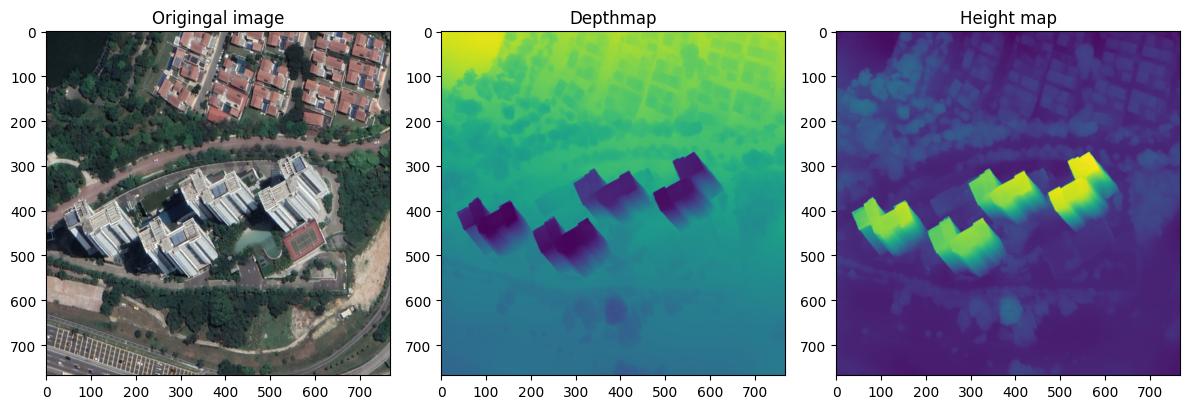

In [6]:
image = cv2.cvtColor(cv2.imread(IMAGE_PATH), cv2.COLOR_RGB2BGR)
image = cv2.resize(image, DST_SIZE)


depth = make_depth(image)
depth = (depth - np.min(depth)) / (np.max(depth) - np.min(depth))


reversed_depth = 1 - depth
reversed_depth_minpool = minpool2d_nearest_pad(reversed_depth, kernel_size=MIN_POOL_KERNEL, padding=MIN_POOL_PADDING)
reversed_depth_minpool_blured = gaussian_filter(reversed_depth_minpool, sigma=GAUSSIAN_BLUR_SIGMA)
depth_nobackground = reversed_depth - reversed_depth_minpool_blured


point_list = []
color_list = []
max_h, max_w = depth_nobackground.shape
for h in range(max_h):
    for w in range(max_w):
        z = depth_nobackground[h, w] 
        
        c = image[h, w, :]
        
        point_list.append((h, w, z))
        color_list.append(c)

point_array, color_array = np.array(point_list), np.array(color_list)


fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # You can adjust figsize as needed
axs[0].imshow(image)
axs[0].set_title('Origingal image')
axs[1].imshow(depth)
axs[1].set_title('Depthmap')
axs[2].imshow(depth_nobackground)
axs[2].set_title('Height map')
plt.tight_layout()
plt.show()

## Generation

In [11]:
note_text = """
<pre>'View 3D Mesh (Web)' slow and sometimes need to be re-runned and mesh quality worse, than point ploud in O3D.</pre>
<pre>'View 3D Cloud (GUI)' needs to be run locally — it’s not supported on platforms like Google Colab or Kaggle.</pre>
<br>
"""

html_multiline = widgets.HTML(
    value=note_text
)

display(html_multiline)

def make_transform_f(kx, ky, bx=0, by=0):
    def f(i):
        return (i[0] + kx*i[2] + bx, i[1] + ky*i[2] + by, i[2]) 
    return f

# Create sliders
slider1 = widgets.IntSlider(value=0, min=-256, max=256, description='DH:')
slider2 = widgets.IntSlider(value=0, min=-256, max=256, description='DW:')
slider3 = widgets.IntSlider(value=128, min=0, max=256, description='Max Z:')
button1 = widgets.Button(description="View 3D Mesh (Web). Slow, ugly.", layout=widgets.Layout(width='250px', height='30px'))
button2 = widgets.Button(description="View 3D Cloud (GUI). Fast, nice.", layout=widgets.Layout(width='250px', height='30px'))

# Create output area
output = widgets.Output()

# Define update function
STATE = {
    'ORIGINAL_IMAGE': image,
    'ORIGINAL_ZMAP': ortho_from_pointcloud(point_array, DST_SIZE[0], DST_SIZE[1], res=1.0),
    'ORTHO_ZMAP': None,
    'ORTHO_IMAGE': None,
    'ORIGINAL_POINTS_ARRAY': point_array.copy(),
    'TRANSFORMED_POINTS_ARRAY': None,
    'COLOR_ARRAY': color_array.copy(),
}
original_ortho = ortho_from_pointcloud(point_array, DST_SIZE[0], DST_SIZE[1], res=1.0)
def update(change):
    with output:
        output.clear_output()

        # Recompute
        kx_raw = slider1.value
        ky_raw = slider2.value
        setpoint_z_scale = slider3.value
        
        kx = kx_raw / DEFAULT_Z_SCALE
        ky = ky_raw / DEFAULT_Z_SCALE
        transform_f = make_transform_f(kx, ky)
        STATE['TRANSFORMED_POINTS_ARRAY'] =  norm_0_to_zscale(np.apply_along_axis(transform_f, axis=-1,
                                                                                  arr=norm_0_to_zscale(STATE['ORIGINAL_POINTS_ARRAY'],
                                                                                                       z_scale=DEFAULT_Z_SCALE)), setpoint_z_scale)
        
        STATE['ORTHO_ZMAP'] = ortho_from_pointcloud(STATE['TRANSFORMED_POINTS_ARRAY'],
                                                    DST_SIZE[0], DST_SIZE[1], res=1.0)
        STATE['ORTHO_IMAGE'] = ortho_from_pointcloud(STATE['TRANSFORMED_POINTS_ARRAY'],
                                                     DST_SIZE[0], DST_SIZE[1], res=1.0,
                                                     colors=STATE['COLOR_ARRAY'])

        # Display
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(STATE['ORIGINAL_ZMAP'])
        axs[0].set_title('Original Height')
        axs[1].imshow(STATE['ORTHO_ZMAP'])
        axs[1].set_title('Transformed Height')
        plt.tight_layout()
        plt.show()
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(STATE['ORIGINAL_IMAGE'])
        axs[0].set_title('Original Image')
        axs[1].imshow(STATE['ORTHO_IMAGE'])
        axs[1].set_title('Transformed Image')
        plt.tight_layout()
        plt.show()


# Define update function
def on_button1_click(b):
    with output:
        output.clear_output()
        convert_point_cloud_to_mesh_and_show(STATE['TRANSFORMED_POINTS_ARRAY'], STATE['COLOR_ARRAY'])
        
def on_button2_click(b):
    with output:
        point_cloud_filter_and_show_o3d(STATE['TRANSFORMED_POINTS_ARRAY'], STATE['COLOR_ARRAY'], THESHOLD_DISTANCE)

# Attach the button click event to the function
button1.on_click(on_button1_click)

# Attach the button click event to the function
button2.on_click(on_button2_click)

# Attach the update function to both sliders
slider1.observe(update, names='value')
slider2.observe(update, names='value')
slider3.observe(update, names='value')

# Display widgets
display(slider1, slider2, slider3, button1, button2, output)

# Trigger once to show initial result
update(None)

HTML(value="\n<pre>'View 3D Mesh (Web)' slow and sometimes need to be re-runned and mesh quality worse, than p…

IntSlider(value=0, description='DH:', max=256, min=-256)

IntSlider(value=0, description='DW:', max=256, min=-256)

IntSlider(value=128, description='Max Z:', max=256)

Button(description='View 3D Mesh (Web). Slow, ugly.', layout=Layout(height='30px', width='250px'), style=Butto…

Button(description='View 3D Cloud (GUI). Fast, nice.', layout=Layout(height='30px', width='250px'), style=Butt…

Output()